In [1]:
# from model import LayoutAwareModernBERT, prepare_modernbert_batch
# from transformers import AutoTokenizer, AutoModel

# model = LayoutAwareModernBERT()
# tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")

# words = ["This", "is", "a", "table"]
# bboxes = [[10, 20, 50, 40], [60, 20, 100, 40], [10, 60, 50, 80], [60, 60, 100, 80]]

# encoded, norm_bboxes = prepare_modernbert_batch(words, bboxes, tokenizer)

# fused_embeddings = model(input_ids=encoded["input_ids"],
#                          attention_mask=encoded["attention_mask"],
#                          bbox=norm_bboxes)

# print(fused_embeddings.shape)  # (B, L, H)


In [1]:
from func_utils.pydataloader import TableDataset, ImageDataset,get_val_from_json
from func_utils.supabase_utils import retreive_data_from_table, init_supabase, load_buffer_to_np
from func_utils.plot_utils import show_image, plot_image_and_bbox, render_bbox
import albumentations as A
import cv2
import os 
import numpy as np

c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def transform_image(image, struct = None, words = None, H = 842, W = 595):
    # Define augmentations
    transform = A.Compose([
        A.CLAHE(p=1.0),
        A.RandomBrightnessContrast(p=0.5),
        A.LongestMaxSize(max_size=max(H, W)),  # ensures the longest side == target max
        A.PadIfNeeded(min_height=H, min_width=W,
                      border_mode=cv2.BORDER_CONSTANT,
                      fill=0),
        A.Resize(864, 864)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids'], clip=True))

    # Extract bboxes from metadata
    bboxes = []
    category_ids = []
    if struct and words:
        sbboxes = get_val_from_json(struct, "bbox", 'objects')
        wbboxes = get_val_from_json(words, "bbox")
        sbboxes_len = len(sbboxes)
        wbboxes_len = len(wbboxes)
        bboxes = sbboxes + wbboxes
        category_ids = list(range(sbboxes_len + wbboxes_len))  
    

    augmented = transform(image=image, bboxes=bboxes, category_ids=category_ids)

    new_bboxes = augmented["bboxes"]
    augmented_ids = augmented["category_ids"]
    return augmented["image"], new_bboxes

In [3]:
supabase = init_supabase()
data = retreive_data_from_table(supabase, limit=100)
tdataset = TableDataset(data, transform = transform_image, img_size=False, channel_first=False, to_torch=False, n_channels=3)

In [4]:
len(data), len(tdataset)

(100, 100)

(864, 864, 3)


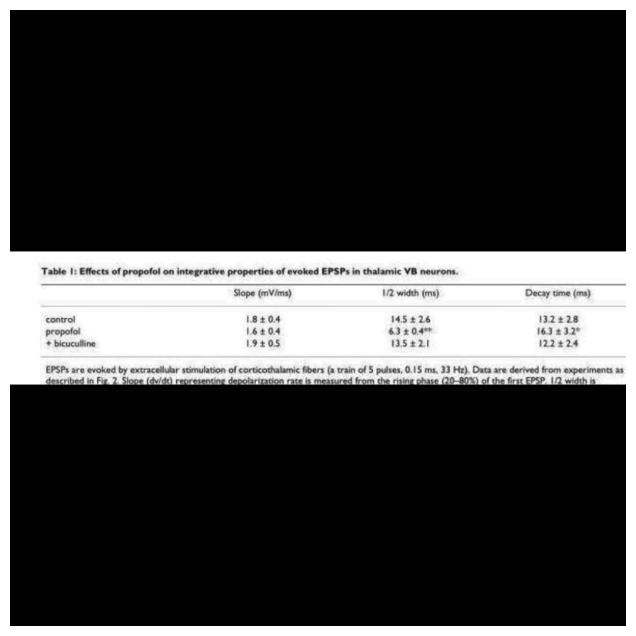

In [5]:
print(tdataset[0]['image'].shape)
show_image(tdataset[0]['image'])

In [6]:
# plot_image_and_bbox([10, 20, 30, 40, 50], tdataset, 'bboxes')

Now we have:

**INPUT**
* Image

**OUTPUT**
* Texts
* Texts Bounding Box
* Table Layout Bounding Box

Found a pre-trained model that's capable of detecting more relavant features for the downstream task 

In [7]:
from doc_analysis_model import load_doclaynet_model, get_doc_bboxes

In [8]:
imgsz = 864
img = tdataset[0]['image']


0: 864x864 1 Section-header, 1 Table, 102.1ms
Speed: 2.8ms preprocess, 102.1ms inference, 1.5ms postprocess per image at shape (1, 3, 864, 864)


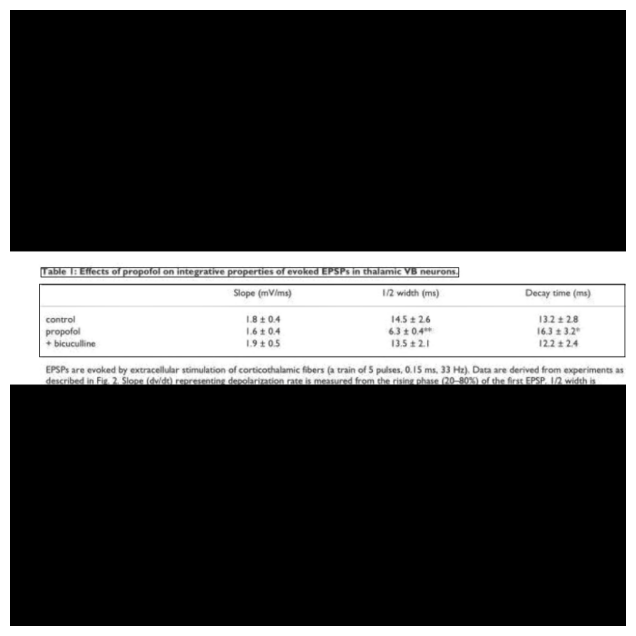

In [10]:
model, device = load_doclaynet_model(model_name=os.path.join('models', 'doclaynet-yolo.pt'))
detections = get_doc_bboxes(model, [img], conf_thresh=0.5, imgsz=imgsz)
show_image(render_bbox(detections[0], img))

In [41]:
from glob import glob
import matplotlib.pyplot as plt

images_path = glob(os.path.join('assets', '*.png'))
N = len(images_path)
N

6

In [42]:
idataset = ImageDataset(images_path, transform_image, 3, False, False, img_size = (864, 864))
images = [idataset[i][0] for i in range(N)]

In [43]:
imgsz = 864
model, device = load_doclaynet_model(model_name=os.path.join('models', 'doclaynet-yolo.pt'))
detections = get_doc_bboxes(model, images, conf_thresh=0.3, imgsz=imgsz)


0: 864x864 11 List-items, 2 Section-headers, 9 Texts, 94.8ms
1: 864x864 1 Caption, 3 Section-headers, 1 Table, 3 Texts, 94.8ms
2: 864x864 1 Footnote, 5 List-items, 1 Page-footer, 1 Page-header, 2 Section-headers, 1 Table, 6 Texts, 94.8ms
3: 864x864 11 List-items, 1 Page-footer, 1 Section-header, 2 Texts, 94.8ms
4: 864x864 2 Section-headers, 1 Table, 3 Texts, 94.8ms
5: 864x864 1 Page-footer, 2 Section-headers, 1 Table, 2 Texts, 94.8ms
Speed: 4.3ms preprocess, 94.8ms inference, 2.7ms postprocess per image at shape (1, 3, 864, 864)


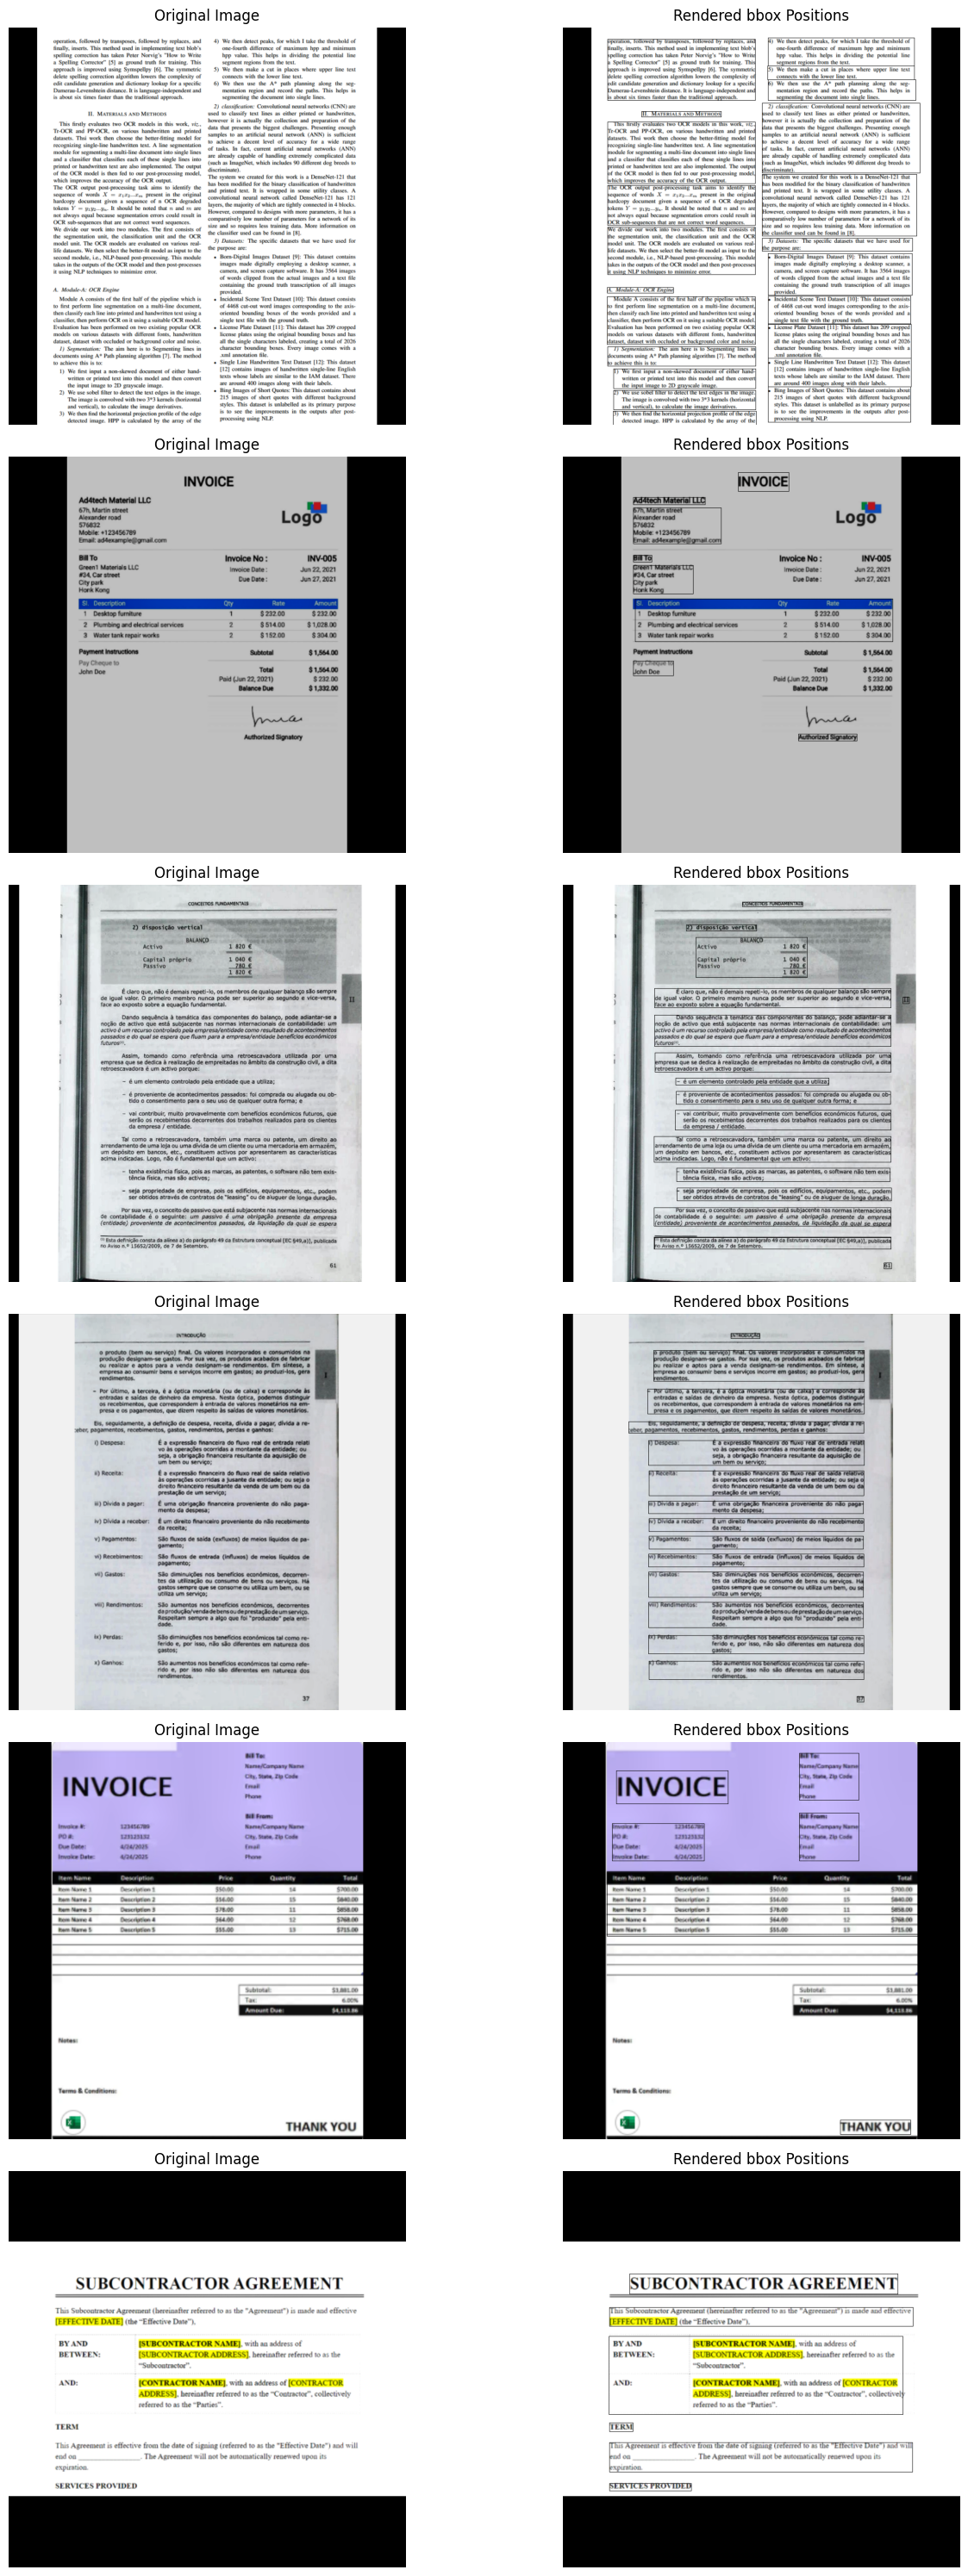

In [44]:
fig, axes = plt.subplots(nrows=N, ncols=2, figsize=(15, 5 * N))  

for i in range(N):
    og_img = images[i]
    op_img = render_bbox(detections[i], og_img)
    ax1 = axes[i,0]
    ax1.imshow(og_img)
    ax1.set_title(f"Original Image")
    ax1.axis('off')

    ax2 = axes[i, 1]
    ax2.imshow(op_img)  
    ax2.set_title("Rendered bbox Positions")
    ax2.axis('off')

plt.tight_layout()
plt.show()